```text
SPDX-License-Identifier: PolyForm-Noncommercial-1.0.0
Autor: Bruno Francisco Barra Atarama
Institución:
  Departamento de Ingeniería Aeroespacial
  Facultad de Ingeniería
  Universidad Nacional de La Plata
Año: 2025
Licencia: PolyForm Noncommercial License 1.0.0
```

**Licencia:** ver [LICENSE](../LICENSE).

# Ejemplo: Wagner

En este ejemplo se compara la respuesta simulada de los coeficientes $C_l$ y $C_d$ al acelerar incial e impulsivamente un perfil hasta una velocidad que permanece en los instantes posteriores y la respuesta teórica de Wagner. $\tau = \frac{2 V_\infty t}{c}$ es el tiempo reducido que depende de la velocidad de la corriente libre $V_\infty$, la cuerda $c$ y el tiempo $t$.

## Bibliotecas y módulos

A continuación, se muestra qué bibliotecas se importan para este ejemplo particular.

El módulo de tipado se recomienda utilizar para aprovechar las ayudas documentadas, sobre todo en los primeros usos.

In [1]:
%matplotlib inline
# Para gráficos interactivos en el notebook. # Para utilizar, instalar ipympl con `pip install ipympl`
# %matplotlib widget    

# Bibliotecas generales
import numpy as np                          # Para hacer operaciones matemáticas
import matplotlib, matplotlib.pyplot as plt # Para graficar

# Módulos propios

# Funcionales
from src.MP2D import MP2D
from src import Cinematicas
from src.Importacion import discretizarPerfil

# Tipado
from src import Tipos

## $C_l$ estacionario



In [2]:
c = 1
V = 100
alfa = 5

r_xy = discretizarPerfil('rec/perfiles/NACA0012_selig.txt', 100, 100, c, 'selig')\

# Estacionario
params : Tipos.AOAParams = {
    'alfa' : [alfa],
    'r_xy' : r_xy,
    'V' : V,
}

cinematica = Cinematicas.cinematica('aoa', params)

refConfig: Tipos.RefConfig = {
    'l' : c,
    'V' : V,
}

mpConfig: Tipos.MPConfig = {
    'estacionario' : True,
    'vorticeArranque' : True,   # El vórtice de arranque tiene que estar para que al principio esté en estado estacionario.
}

mp = MP2D(cinematica, mpConfig=mpConfig, refConfig=refConfig)

mp.simular()

Cl_estacionario = mp.CxyTotalRec[0][1]

print(f'Cl estacionario: {Cl_estacionario:.4f}')

Simulando: 100%|██████████| 1/1 [00:00<00:00, 83.27 pasos/s]

Cl estacionario: 0.5948


## Simulación

Para modelar la aceleración impulsiva, en el primer instante se simuló al perfil en reposo y un instante posterior se lo dotó con la velocidad final, asumiendo que en el transcurso entre el primer instante y el siguiente la velocidad ya era la final y se trasladó la distancia correspondiente a este movimiento.

In [3]:
# Primer instante
V1 = 0
t = [0]
params : Tipos.MRUParams = {
    'alfa' : alfa,
    'r_xy' : r_xy,
    't' : t,
    'V' : V1,
}

cinematica = Cinematicas.cinematica('mru', params)

mpConfig: Tipos.MPConfig = {
    'estacionario' : False,
    'vorticeArranque' : True,   # El vórtice de arranque tiene que estar para que al principio esté en estado estacionario.
    'nombres' : 'MP2D',
}

mp = MP2D(cinematica, mpConfig=mpConfig, refConfig=refConfig)

mp.simular(1)

# Instantes posteriores
DtUinf_c = 0.02
tUinf_c_final = 9

#dt = 3e-4

Dt = DtUinf_c * c / V
tFinal = tUinf_c_final * c / V
t = np.arange(0, tFinal, Dt)[1:]

params: Tipos.MRUParams = {
    'alfa' : alfa,
    'r_xy' : r_xy,
    't' : t,
    'V' : V,
}

cinematica = Cinematicas.cinematica('mru', params)

next(cinematica)    # Se purga un paso para que el perfil no vuelva a estar en el origen si no en la siguiente posición.

mp.cinematicas = [cinematica]

mp.simular()

Simulando: 100%|██████████| 448/448 [00:10<00:00, 42.58 pasos/s]


## Resultados

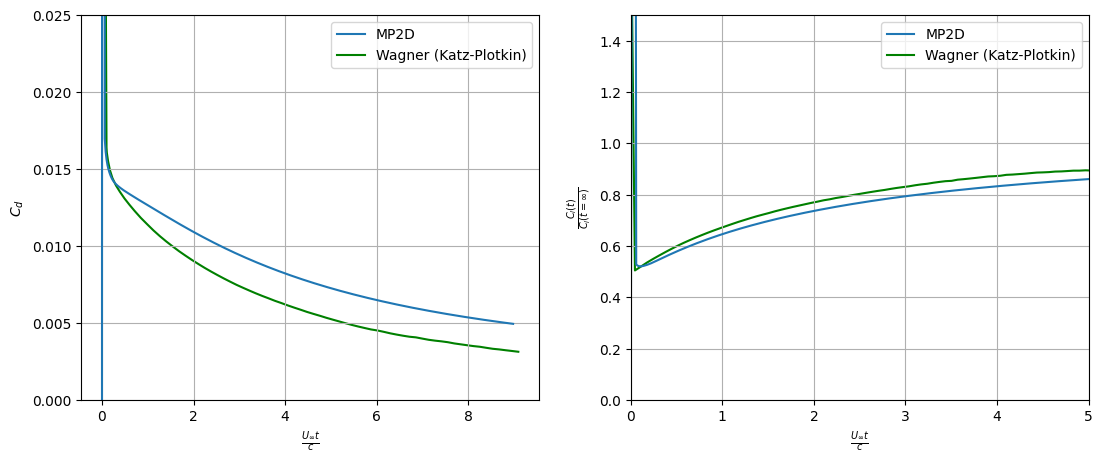

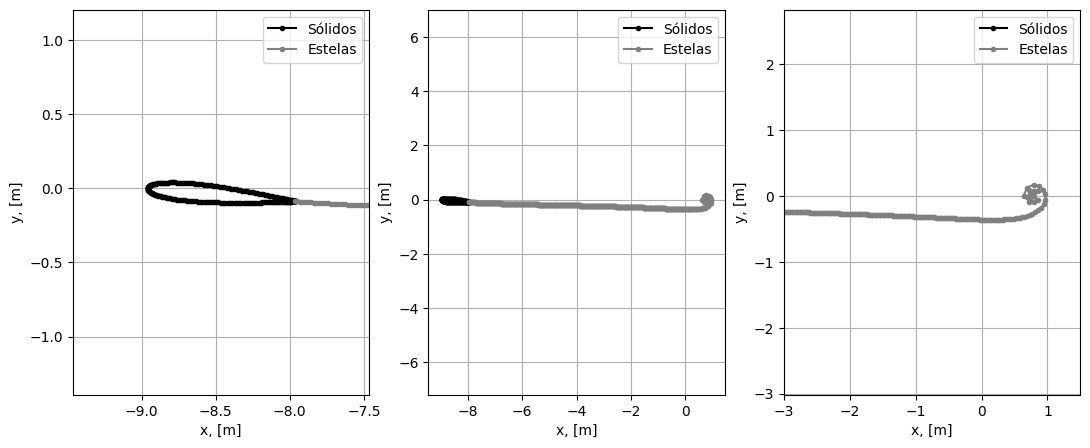

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

Cd = [Cxy[0] for Cxy in mp.CxyTotalRec]
Cl = [Cxy[1] for Cxy in mp.CxyTotalRec]

tau = V * np.asarray(mp.t) / c

ax[0].plot(tau, Cd, label='MP2D')
ax[1].plot(tau, Cl/Cl_estacionario, label='MP2D')
ax[1].set_ylim(0, 1.5)

# Respuesta de Wagner

tau_Cd, Cd_wagner = np.loadtxt("rec/Wagner - Cd.csv", delimiter=",", unpack=True, skiprows=1)
tau_Cl, Cl_wagner = np.loadtxt("rec/Wagner - Cl.csv", delimiter=",", unpack=True, skiprows=1)
ax[0].plot(tau_Cd, Cd_wagner, color='green', label='Wagner (Katz-Plotkin)', zorder=0)
ax[1].plot(tau_Cl, Cl_wagner, color='green', label='Wagner (Katz-Plotkin)', zorder=0)
ax[0].legend()
ax[1].legend()

ax[0].set_ylim(0, 0.025)
ax[1].set_xlim(0, 5)

ax[0].set_ylabel(r'$C_d$')
ax[1].set_ylabel(r'$\frac{C_l(t)}{C_l(t=\infty)}$')
ax[0].set_xlabel(r'$\frac{U_\infty t}{c}$')
ax[1].set_xlabel(r'$\frac{U_\infty t}{c}$')

ax[0].grid(True)
ax[1].grid(True)

fig, ax = plt.subplots(1, 3, figsize=(13, 5))
mp.plotPaneles(-1, ax=ax[0])
mp.plotPaneles(-1, ax=ax[1])
mp.plotPaneles(-1, ax=ax[2])
BF = mp.conjuntos[-1].solidos[0].r_xy[0, 0]
ax[0].set_xlim([BF - 1.5, BF + 0.5])
ax[2].set_xlim([-3, 1.5])

plt.show()

Como se puede ver en la figura, las respuestas difieren pero comparten las características fundamentales del experimento:

- El $C_d$ es infinito al comienzo debido a la componente de masa añadida (inercia del fluido) infinita por la aceleración impulsiva, que decae con el tiempo hasta $0$.
	 
- El $C_l$ también es infinito al inicio por el mismo motivo, cae hasta la mitad de $C_{l,\infty}$ en $0^+$ y luego crece tendiendo al valor estacionario por la componente circulatoria.

En este experimento también puede apreciarse el desarrollo del vórtice de arranque en la estela.

## Conclusión

La implementación del método de los paneles responde de forma similar a la teoría de placa plana, contribuyendo a la validez en el caso no estacionario.